<a href="https://colab.research.google.com/github/raoaneesh24-pixel/Physics-Portfolio/blob/main/Lagrange_Point_Stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  LAGRANGE POINT STABILITY — IB PHYSICS EE SIMULATION
  Displacement from L4: 1.0% of d
  Simulating 20 orbits per mass ratio
  Time step: 6.0 hours
  Theoretical stability threshold: M/m > 24.96

Plotting effective potential landscape...


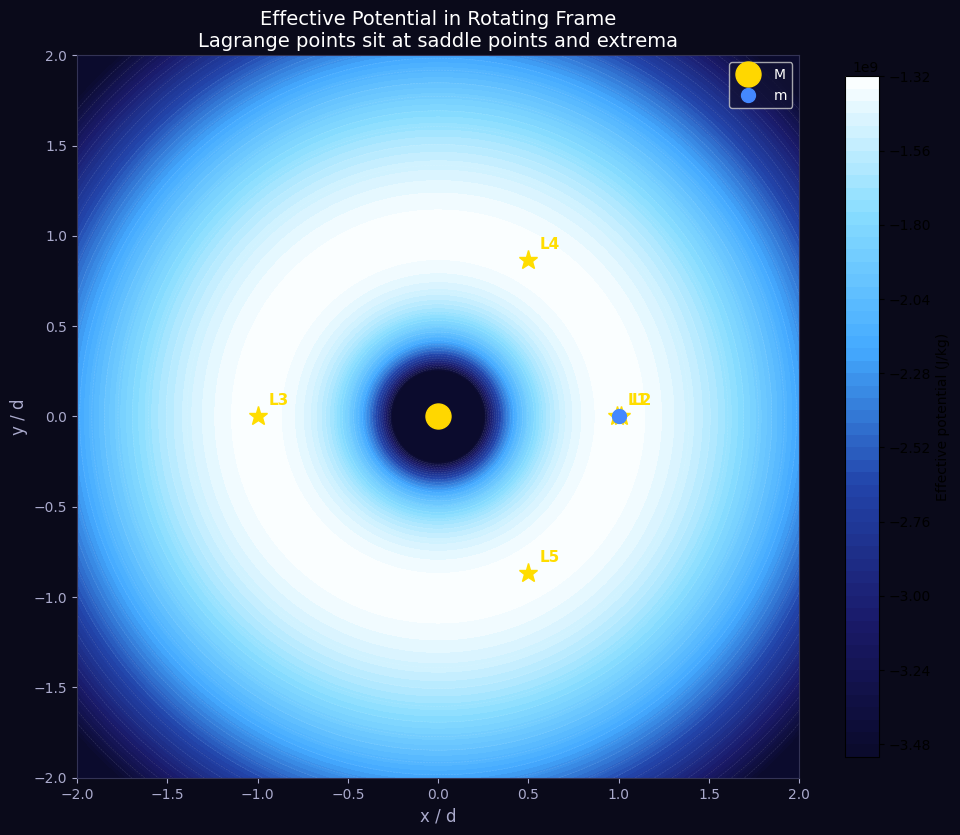

  Saved: effective_potential.png

Running energy validation (M/m = 1000, stable case)...


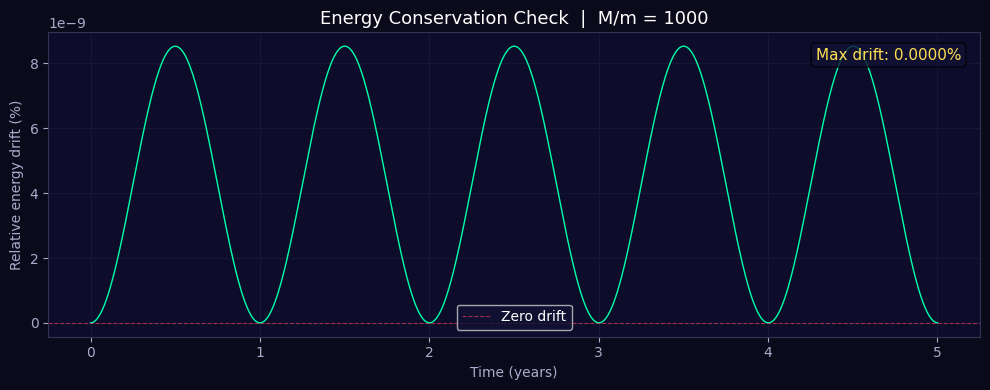

  Saved: energy_conservation.png

Running stable example (M/m = 1000)...


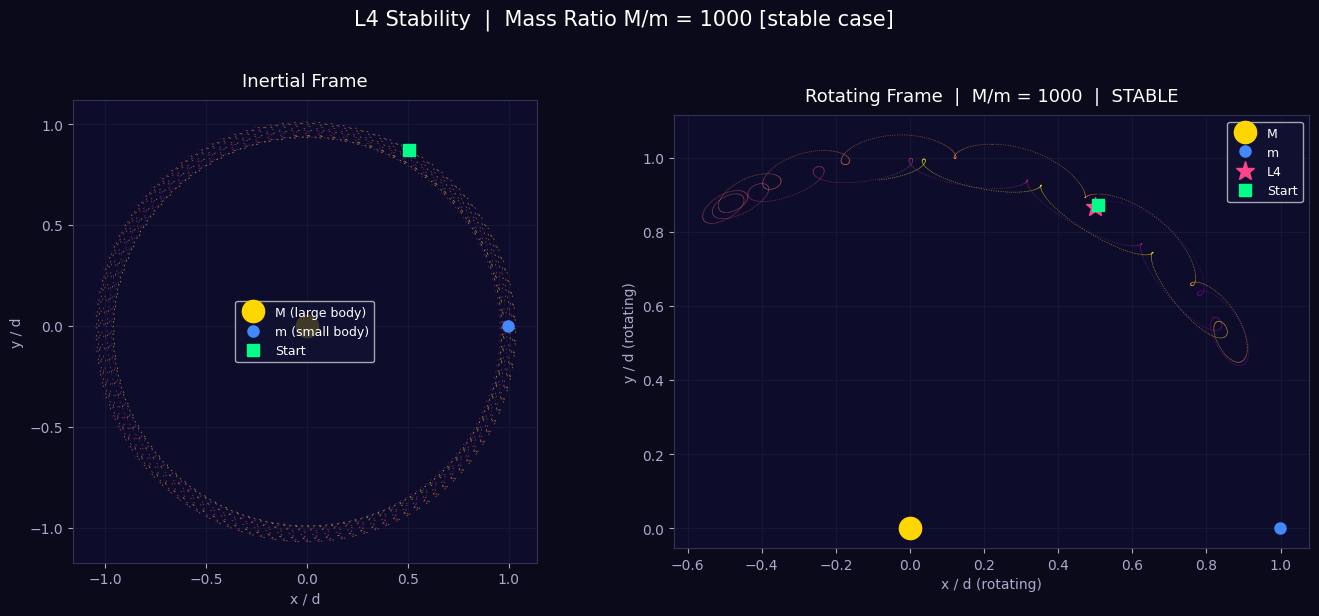

  Saved: trajectory_ratio_1000.png

Running unstable example (M/m = 10)...


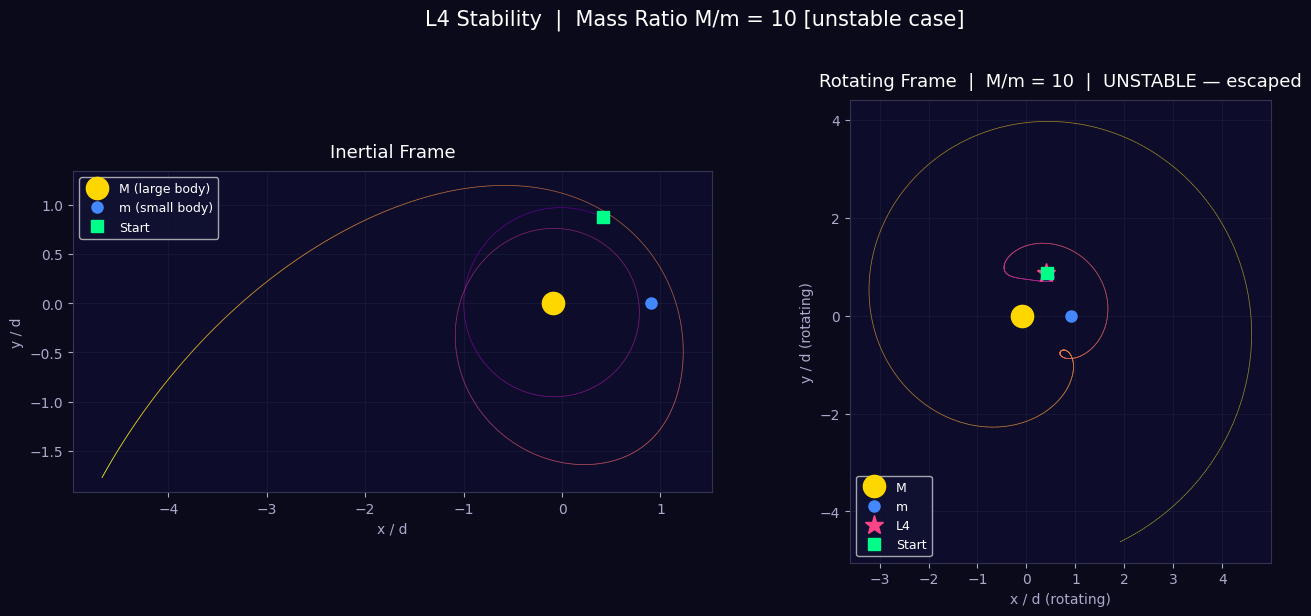

  Saved: trajectory_ratio_10.png

Running full mass ratio sweep...
  Testing 11 mass ratios: [16, 18, 20, 22, 24.96, 30, 50, 100, 500, 1000, 10000]

  Simulating M/m =       16... max disp = 5.065d
  Simulating M/m =       18... ESCAPED
  Simulating M/m =       20... ESCAPED
  Simulating M/m =       22... ESCAPED
  Simulating M/m =    24.96... max disp = 2.554d
  Simulating M/m =       30... ESCAPED
  Simulating M/m =       50... max disp = 0.519d
  Simulating M/m =      100... max disp = 0.374d
  Simulating M/m =      500... max disp = 0.714d
  Simulating M/m =     1000... max disp = 1.059d
  Simulating M/m =    10000... max disp = 1.985d

──────────────────────────────────────────────────
  Mass Ratio    Max Displacement   Stability
──────────────────────────────────────────────────
          16             5.065d      stable
          18             4.044d    UNSTABLE
          20             5.295d    UNSTABLE
          22             5.613d    UNSTABLE
       24.96             2.5

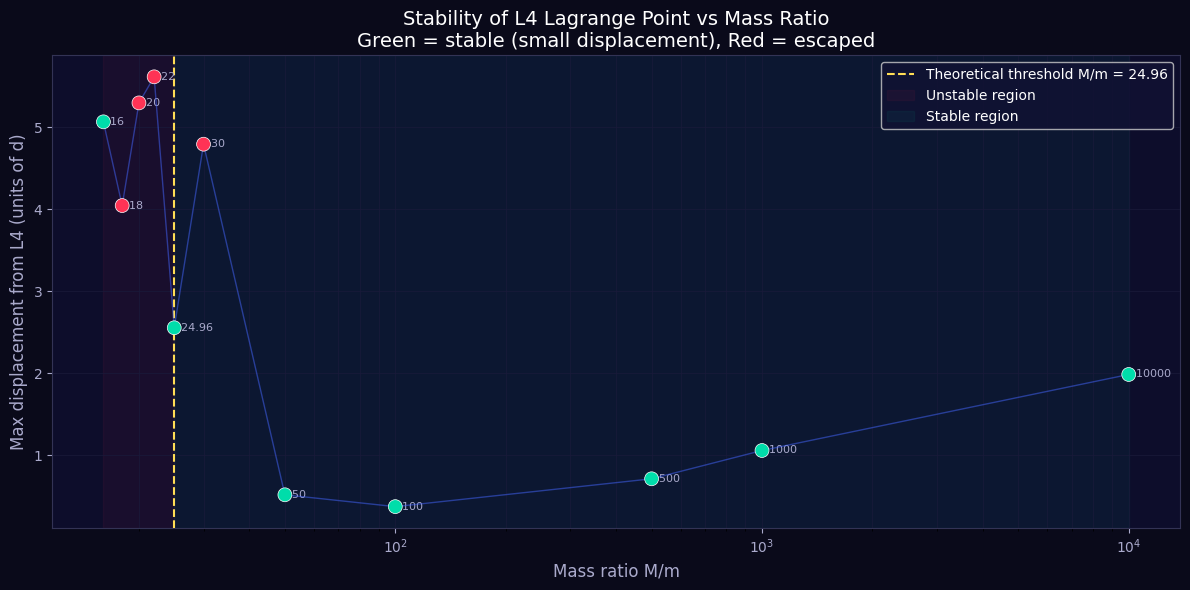

  Saved: stability_map.png

All done! Files saved:
  effective_potential.png  — theory background
  energy_conservation.png  — numerical validation
  trajectory_ratio_*.png   — example trajectories
  stability_map.png        — KEY EE RESULT


In [1]:
"""
Lagrange Point Stability Simulation
IB Physics Extended Essay?
Research Question: How does the mass ratio of two primary bodies affect
the stability of a test particle near the L4 Lagrange point?

Usage:
    python lagrange_stability_sim.py

Requirements:
    pip install numpy matplotlib scipy
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')


# ═══════════════════════════════════════════════════════════════
# CONFIGURATION — change your experiment parameters here
# ═══════════════════════════════════════════════════════════════

G = 6.674e-11          # gravitational constant (SI)
d = 1.5e11             # separation between primaries (metres) — 1 AU

# --- Simulation accuracy ---
dt = 3600 * 6          # time step in seconds (6 hours)
N_ORBITS = 20          # how many orbits of m around M to simulate

# --- EE experiment: mass ratios to test ---
# Theoretical stability threshold: M/m > 24.96
# We test a range spanning below and above this threshold
MASS_RATIOS = [16, 18, 20, 22, 24.96, 30, 50, 100, 500, 1000, 10000]      #originally: [5, 10, 15, 20, 24.96, 30, 50, 100, 500, 1000, 10000]

# --- Initial displacement of test particle from L4 ---
# Expressed as a fraction of d. Try 0.01 (1%) and 0.05 (5%)
DISPLACEMENT_FRACTION = 0.01

# --- Fixed mass of large body ---
M_FIXED = 2e30         # ~1 solar mass


# ═══════════════════════════════════════════════════════════════
# PHYSICS: FORCE AND ACCELERATION
# ═══════════════════════════════════════════════════════════════

def gravitational_acceleration(pos_self, pos_other, mass_other):
    """
    Acceleration of a body due to gravity from one other body.
    Returns a 2D vector.
    """
    r_vec = pos_other - pos_self
    r_mag = np.linalg.norm(r_vec)
    if r_mag < 1e6:          # softening: avoid singularity if bodies overlap
        return np.zeros(2)
    return G * mass_other / r_mag**2 * (r_vec / r_mag)


def compute_all_accelerations(r_M, r_m, r_p, M, m):
    """
    Net acceleration on each of the three bodies.
    Test particle mass is negligible (doesn't affect primaries in EE approximation).
    For full accuracy we include it anyway with mass = 1 kg.
    """
    mp = 1.0   # test particle mass (negligible)

    a_M = (gravitational_acceleration(r_M, r_m, m)
         + gravitational_acceleration(r_M, r_p, mp))

    a_m = (gravitational_acceleration(r_m, r_M, M)
         + gravitational_acceleration(r_m, r_p, mp))

    a_p = (gravitational_acceleration(r_p, r_M, M)
         + gravitational_acceleration(r_p, r_m, m))

    return a_M, a_m, a_p


# ═══════════════════════════════════════════════════════════════
# NUMERICS: LEAPFROG INTEGRATOR
# ═══════════════════════════════════════════════════════════════

def leapfrog_step(r_M, v_M, r_m, v_m, r_p, v_p, M, m, dt):
    """
    One leapfrog (Verlet) integration step.
    Symplectic method — conserves energy well over long runs.
    """
    # 1. Accelerations at current positions
    a_M, a_m, a_p = compute_all_accelerations(r_M, r_m, r_p, M, m)

    # 2. Half-step velocity update
    v_M_h = v_M + 0.5 * a_M * dt
    v_m_h = v_m + 0.5 * a_m * dt
    v_p_h = v_p + 0.5 * a_p * dt

    # 3. Full-step position update
    r_M_new = r_M + v_M_h * dt
    r_m_new = r_m + v_m_h * dt
    r_p_new = r_p + v_p_h * dt

    # 4. Recompute accelerations at new positions
    a_M_new, a_m_new, a_p_new = compute_all_accelerations(
        r_M_new, r_m_new, r_p_new, M, m
    )

    # 5. Second half-step velocity update
    v_M_new = v_M_h + 0.5 * a_M_new * dt
    v_m_new = v_m_h + 0.5 * a_m_new * dt
    v_p_new = v_p_h + 0.5 * a_p_new * dt

    return r_M_new, v_M_new, r_m_new, v_m_new, r_p_new, v_p_new


# ═══════════════════════════════════════════════════════════════
# INITIAL CONDITIONS
# ═══════════════════════════════════════════════════════════════

def setup_initial_conditions(M, m, displacement_fraction=0.01):
    """
    Place M and m in circular orbits around their centre of mass.
    Place test particle at L4 + small displacement.
    Returns positions and velocities as 2D numpy arrays.
    """
    omega = np.sqrt(G * (M + m) / d**3)    # orbital angular velocity

    # Centre of mass at origin → positions on x-axis
    r_M0 = np.array([-m * d / (M + m), 0.0])
    r_m0 = np.array([ M * d / (M + m), 0.0])

    # Circular orbit velocities (perpendicular to position vector)
    v_M0 = np.array([0.0, -omega * abs(r_M0[0])])
    v_m0 = np.array([0.0,  omega * abs(r_m0[0])])

    # L4 position: equilateral triangle with M and m, 60° ahead of m
    # In our coordinate system with M at negative x, m at positive x:
    L4 = np.array([
        (r_M0[0] + r_m0[0]) / 2,        # midpoint x
        np.sqrt(3) / 2 * d               # height of equilateral triangle
    ])

    # Small displacement (random direction for generality)
    disp_mag = displacement_fraction * d
    angle = np.pi / 4                     # 45° displacement — can vary this
    displacement = disp_mag * np.array([np.cos(angle), np.sin(angle)])

    r_p0 = L4 + displacement

    # Test particle velocity: co-rotating with the system
    v_p0 = np.array([-omega * r_p0[1], omega * r_p0[0]])

    return r_M0, v_M0, r_m0, v_m0, r_p0, v_p0, omega, L4


# ═══════════════════════════════════════════════════════════════
# ENERGY: VALIDATION CHECK
# ═══════════════════════════════════════════════════════════════

def total_energy(r_M, v_M, r_m, v_m, r_p, v_p, M, m):
    """
    Total mechanical energy of the system (KE + PE).
    Should be approximately conserved — use to validate simulation.
    """
    mp = 1.0

    KE = (0.5 * M  * np.dot(v_M, v_M)
        + 0.5 * m  * np.dot(v_m, v_m)
        + 0.5 * mp * np.dot(v_p, v_p))

    r_Mm = np.linalg.norm(r_m - r_M)
    r_Mp = np.linalg.norm(r_p - r_M)
    r_mp = np.linalg.norm(r_p - r_m)

    PE = (-G * M * m  / r_Mm
        - G * M * mp / r_Mp
        - G * m * mp / r_mp)

    return KE + PE


# ═══════════════════════════════════════════════════════════════
# ROTATING FRAME TRANSFORM
# ═══════════════════════════════════════════════════════════════

def to_rotating_frame(r, omega, t):
    """
    Transform position from inertial frame to rotating frame.
    In the rotating frame, M and m are stationary on the x-axis —
    this makes tadpole orbits around L4 clearly visible.
    """
    theta = -omega * t     # rotation angle
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    x_rot = cos_t * r[0] - sin_t * r[1]
    y_rot = sin_t * r[0] + cos_t * r[1]
    return np.array([x_rot, y_rot])


# ═══════════════════════════════════════════════════════════════
# STABILITY METRIC
# ═══════════════════════════════════════════════════════════════

def stability_metric(traj_rot, L4_rot):
    """
    Measure how far the particle strayed from L4 over the simulation.
    Returns max distance from L4 (in units of d).
    A small value = stable. Large value = unstable/escaped.
    """
    distances = np.linalg.norm(traj_rot - L4_rot, axis=1)
    return np.max(distances) / d


# ═══════════════════════════════════════════════════════════════
# CORE SIMULATION RUNNER
# ═══════════════════════════════════════════════════════════════

def run_simulation(mass_ratio, n_orbits=N_ORBITS, record_energy=False):
    """
    Run a full simulation for a given mass ratio M/m.
    Returns trajectory data and stability metric.
    """
    M = M_FIXED
    m = M / mass_ratio

    r_M, v_M, r_m, v_m, r_p, v_p, omega, L4 = setup_initial_conditions(
        M, m, DISPLACEMENT_FRACTION
    )

    # Orbital period of m around M
    T_orbit = 2 * np.pi / omega
    n_steps = int(n_orbits * T_orbit / dt)

    # Storage
    traj_inertial = np.zeros((n_steps, 2))
    traj_rotating = np.zeros((n_steps, 2))
    energies = np.zeros(n_steps) if record_energy else None
    times = np.zeros(n_steps)

    t = 0.0
    for i in range(n_steps):
        # Record state
        traj_inertial[i] = r_p
        traj_rotating[i] = to_rotating_frame(r_p, omega, t)
        if record_energy:
            energies[i] = total_energy(r_M, v_M, r_m, v_m, r_p, v_p, M, m)
        times[i] = t

        # Advance
        r_M, v_M, r_m, v_m, r_p, v_p = leapfrog_step(
            r_M, v_M, r_m, v_m, r_p, v_p, M, m, dt
        )
        t += dt

        # Early exit if particle escapes (> 5x orbital separation)
        if np.linalg.norm(r_p) > 5 * d:
            traj_inertial = traj_inertial[:i+1]
            traj_rotating = traj_rotating[:i+1]
            if record_energy:
                energies = energies[:i+1]
            times = times[:i+1]
            break

    # L4 in rotating frame is fixed at its initial position
    L4_rot = to_rotating_frame(L4, omega, 0)

    metric = stability_metric(traj_rotating, L4_rot)

    return {
        'traj_inertial': traj_inertial,
        'traj_rotating': traj_rotating,
        'energies': energies,
        'times': times,
        'omega': omega,
        'L4': L4,
        'L4_rot': L4_rot,
        'r_M_init': np.array([-m * d / (M + m), 0.0]),
        'r_m_init': np.array([ M * d / (M + m), 0.0]),
        'metric': metric,
        'mass_ratio': mass_ratio,
        'escaped': len(times) < int(n_orbits * 2 * np.pi / (np.sqrt(G*(M+m)/d**3)) / dt)
    }


# ═══════════════════════════════════════════════════════════════
# PLOTTING
# ═══════════════════════════════════════════════════════════════

def plot_single_trajectory(result, title_suffix=""):
    """
    Plot inertial + rotating frame trajectories for one mass ratio.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.patch.set_facecolor('#0a0a1a')
    for ax in axes:
        ax.set_facecolor('#0d0d2b')

    ratio = result['mass_ratio']
    traj_i = result['traj_inertial'] / d
    traj_r = result['traj_rotating'] / d
    L4_r   = result['L4_rot'] / d

    # Colour trajectory by time (early = bright, late = dim)
    n = len(traj_i)
    colors_i = plt.cm.plasma(np.linspace(0.2, 1.0, n))
    colors_r = plt.cm.plasma(np.linspace(0.2, 1.0, n))

    # --- Inertial frame ---
    ax = axes[0]
    for j in range(0, n-1, max(1, n//2000)):
        ax.plot(traj_i[j:j+2, 0], traj_i[j:j+2, 1],
                color=colors_i[j], lw=0.5, alpha=0.7)

    r_M_i = result['r_M_init'] / d
    r_m_i = result['r_m_init'] / d
    ax.plot(*r_M_i, 'o', color='#FFD700', markersize=16, label='M (large body)', zorder=5)
    ax.plot(*r_m_i, 'o', color='#4488FF', markersize=8,  label='m (small body)', zorder=5)
    ax.plot(traj_i[0, 0], traj_i[0, 1], 's', color='#00FF88',
            markersize=8, label='Start', zorder=5)

    ax.set_title('Inertial Frame', color='white', fontsize=13, pad=10)
    ax.set_xlabel('x / d', color='#aaaacc')
    ax.set_ylabel('y / d', color='#aaaacc')
    ax.tick_params(colors='#aaaacc')
    for spine in ax.spines.values():
        spine.set_color('#333355')
    ax.legend(facecolor='#111133', labelcolor='white', fontsize=9)
    ax.set_aspect('equal')
    ax.grid(color='#1a1a3a', linewidth=0.5)

    # --- Rotating frame ---
    ax = axes[1]
    for j in range(0, n-1, max(1, n//2000)):
        ax.plot(traj_r[j:j+2, 0], traj_r[j:j+2, 1],
                color=colors_r[j], lw=0.5, alpha=0.7)

    ax.plot(r_M_i[0], 0, 'o', color='#FFD700', markersize=16, label='M', zorder=5)
    ax.plot(r_m_i[1] if False else result['r_m_init'][0]/d, 0,
            'o', color='#4488FF', markersize=8, label='m', zorder=5)
    ax.plot(*L4_r, '*', color='#FF4488', markersize=14, label='L4', zorder=5)
    ax.plot(traj_r[0, 0], traj_r[0, 1], 's', color='#00FF88',
            markersize=8, label='Start', zorder=5)

    status = "UNSTABLE — escaped" if result['escaped'] else "STABLE"
    ax.set_title(f'Rotating Frame  |  M/m = {ratio}  |  {status}',
                 color='white', fontsize=13, pad=10)
    ax.set_xlabel('x / d (rotating)', color='#aaaacc')
    ax.set_ylabel('y / d (rotating)', color='#aaaacc')
    ax.tick_params(colors='#aaaacc')
    for spine in ax.spines.values():
        spine.set_color('#333355')
    ax.legend(facecolor='#111133', labelcolor='white', fontsize=9)
    ax.set_aspect('equal')
    ax.grid(color='#1a1a3a', linewidth=0.5)

    plt.suptitle(f'L4 Stability  |  Mass Ratio M/m = {ratio}{title_suffix}',
                 color='white', fontsize=15, y=1.02)
    plt.tight_layout()
    plt.savefig(f'trajectory_ratio_{ratio}.png', dpi=150,
                bbox_inches='tight', facecolor='#0a0a1a')
    plt.show()
    print(f"  Saved: trajectory_ratio_{ratio}.png")


def plot_energy_conservation(result):
    """
    Plot total energy over time to validate the simulation.
    A flat line = trustworthy numerics.
    """
    if result['energies'] is None:
        print("  No energy data recorded. Re-run with record_energy=True.")
        return

    fig, ax = plt.subplots(figsize=(10, 4))
    fig.patch.set_facecolor('#0a0a1a')
    ax.set_facecolor('#0d0d2b')

    E = result['energies']
    E0 = E[0]
    rel_error = (E - E0) / abs(E0) * 100    # percentage drift from initial

    t_years = result['times'] / (3600 * 24 * 365.25)

    ax.plot(t_years, rel_error, color='#00FFAA', lw=1.0)
    ax.axhline(0, color='#FF4455', lw=0.8, linestyle='--', alpha=0.6, label='Zero drift')

    ax.set_xlabel('Time (years)', color='#aaaacc')
    ax.set_ylabel('Relative energy drift (%)', color='#aaaacc')
    ax.set_title(f'Energy Conservation Check  |  M/m = {result["mass_ratio"]}',
                 color='white', fontsize=13)
    ax.tick_params(colors='#aaaacc')
    for spine in ax.spines.values():
        spine.set_color('#333355')
    ax.legend(facecolor='#111133', labelcolor='white')
    ax.grid(color='#1a1a3a', linewidth=0.5)

    max_drift = np.max(np.abs(rel_error))
    ax.text(0.98, 0.95, f'Max drift: {max_drift:.4f}%',
            transform=ax.transAxes, ha='right', va='top',
            color='#FFDD55', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='#111133', alpha=0.8))

    plt.tight_layout()
    plt.savefig('energy_conservation.png', dpi=150,
                bbox_inches='tight', facecolor='#0a0a1a')
    plt.show()
    print("  Saved: energy_conservation.png")


def plot_stability_map(ratios, metrics, escaped_flags):
    """
    THE KEY EE RESULT: max displacement from L4 vs mass ratio.
    This is where you should see the stability transition near M/m = 24.96.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('#0a0a1a')
    ax.set_facecolor('#0d0d2b')

    # Colour points by stability
    colors = ['#FF3355' if esc else '#00DDAA' for esc in escaped_flags]

    ax.scatter(ratios, metrics, c=colors, s=100, zorder=5, edgecolors='white',
               linewidths=0.5)
    ax.plot(ratios, metrics, color='#4466FF', lw=1.0, alpha=0.5, zorder=4)

    # Theoretical threshold line
    threshold = 24.96
    ax.axvline(threshold, color='#FFDD55', lw=1.5, linestyle='--',
               label=f'Theoretical threshold M/m = {threshold}', zorder=3)

    # Shade stable / unstable regions
    ax.axvspan(min(ratios), threshold, alpha=0.05, color='#FF3355', label='Unstable region')
    ax.axvspan(threshold, max(ratios), alpha=0.05, color='#00DDAA', label='Stable region')

    # Annotate points
    for r, m_, esc in zip(ratios, metrics, escaped_flags):
        label = 'escaped' if esc else f'{m_:.2f}d'
        ax.annotate(f'  {r}', (r, m_), color='#aaaacc', fontsize=8,
                    va='center')

    ax.set_xscale('log')
    ax.set_xlabel('Mass ratio M/m', color='#aaaacc', fontsize=12)
    ax.set_ylabel('Max displacement from L4 (units of d)', color='#aaaacc', fontsize=12)
    ax.set_title('Stability of L4 Lagrange Point vs Mass Ratio\n'
                 'Green = stable (small displacement), Red = escaped',
                 color='white', fontsize=14)
    ax.tick_params(colors='#aaaacc')
    for spine in ax.spines.values():
        spine.set_color('#333355')
    ax.legend(facecolor='#111133', labelcolor='white', fontsize=10)
    ax.grid(color='#1a1a3a', linewidth=0.5, which='both')

    plt.tight_layout()
    plt.savefig('stability_map.png', dpi=150,
                bbox_inches='tight', facecolor='#0a0a1a')
    plt.show()
    print("  Saved: stability_map.png")


def plot_effective_potential():
    """
    Visualise the effective potential landscape in the rotating frame.
    Lagrange points appear as saddle points / extrema — great for your EE intro.
    Uses Sun-Earth mass ratio (large and stable) for clarity.
    """
    print("\nPlotting effective potential landscape...")

    M = M_FIXED
    m = M / 333000        # ~Sun-Earth ratio (very stable, clear L4/L5)
    omega = np.sqrt(G * (M + m) / d**3)

    r_M_x = -m * d / (M + m)
    r_m_x =  M * d / (M + m)

    # 2D grid in rotating frame
    x = np.linspace(-2.0 * d, 2.0 * d, 400)
    y = np.linspace(-2.0 * d, 2.0 * d, 400)
    X, Y = np.meshgrid(x, y)

    dist_M = np.sqrt((X - r_M_x)**2 + Y**2)
    dist_m = np.sqrt((X - r_m_x)**2 + Y**2)
    rho     = np.sqrt(X**2 + Y**2)     # distance from rotation axis

    # Effective potential = gravity from M + gravity from m + centrifugal
    with np.errstate(divide='ignore', invalid='ignore'):
        Phi = (-G * M / dist_M
               - G * m / dist_m
               - 0.5 * omega**2 * rho**2)

    # Clip for visualisation (singularities near M and m are very deep)
    Phi_plot = np.clip(Phi, np.percentile(Phi, 2), np.percentile(Phi, 99))

    fig, ax = plt.subplots(figsize=(10, 9))
    fig.patch.set_facecolor('#0a0a1a')
    ax.set_facecolor('#0d0d2b')

    cmap = LinearSegmentedColormap.from_list(
        'eff_pot', ['#0a0a2a', '#1a1a6a', '#2244aa', '#44aaff', '#88ddff', '#ffffff']
    )
    cf = ax.contourf(X/d, Y/d, Phi_plot, levels=60, cmap=cmap)
    ax.contour(X/d, Y/d, Phi_plot, levels=25, colors='white', alpha=0.15, linewidths=0.4)

    plt.colorbar(cf, ax=ax, label='Effective potential (J/kg)', shrink=0.8)

    # Mark Lagrange points (approximate positions)
    L_points = {
        'L1': (0.99, 0),      # between M and m (approximate)
        'L2': (1.01, 0),      # beyond m
        'L3': (-1.0, 0),      # opposite side
        'L4': (0.5, np.sqrt(3)/2),
        'L5': (0.5, -np.sqrt(3)/2),
    }
    for name, (lx, ly) in L_points.items():
        ax.plot(lx, ly, '*', color='#FFDD00', markersize=14, zorder=5)
        ax.annotate(name, (lx, ly), textcoords='offset points', xytext=(8, 8),
                    color='#FFDD00', fontsize=11, fontweight='bold')

    ax.plot(r_M_x/d, 0, 'o', color='#FFD700', markersize=18, label='M', zorder=6)
    ax.plot(r_m_x/d, 0, 'o', color='#4488FF', markersize=10, label='m', zorder=6)

    ax.set_xlabel('x / d', color='#aaaacc', fontsize=12)
    ax.set_ylabel('y / d', color='#aaaacc', fontsize=12)
    ax.set_title('Effective Potential in Rotating Frame\n'
                 'Lagrange points sit at saddle points and extrema',
                 color='white', fontsize=14)
    ax.tick_params(colors='#aaaacc')
    for spine in ax.spines.values():
        spine.set_color('#333355')
    ax.legend(facecolor='#111133', labelcolor='white')
    ax.set_aspect('equal')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    plt.tight_layout()
    plt.savefig('effective_potential.png', dpi=150,
                bbox_inches='tight', facecolor='#0a0a1a')
    plt.show()
    print("  Saved: effective_potential.png")


# ═══════════════════════════════════════════════════════════════
# MAIN: RUN THE FULL EE EXPERIMENT
# ═══════════════════════════════════════════════════════════════

if __name__ == '__main__':

    print("=" * 60)
    print("  LAGRANGE POINT STABILITY — IB PHYSICS EE SIMULATION")
    print("=" * 60)
    print(f"  Displacement from L4: {DISPLACEMENT_FRACTION*100:.1f}% of d")
    print(f"  Simulating {N_ORBITS} orbits per mass ratio")
    print(f"  Time step: {dt/3600:.1f} hours")
    print(f"  Theoretical stability threshold: M/m > 24.96")
    print("=" * 60)

    # ── 1. Effective potential landscape (background theory, no simulation needed)
    plot_effective_potential()

    # ── 2. Energy conservation check (validate numerics before trusting results)
    print("\nRunning energy validation (M/m = 1000, stable case)...")
    validation = run_simulation(1000, n_orbits=5, record_energy=True)
    plot_energy_conservation(validation)

    # ── 3. Show two contrasting trajectories: stable vs unstable
    print("\nRunning stable example (M/m = 1000)...")
    stable_result = run_simulation(1000, n_orbits=N_ORBITS)
    plot_single_trajectory(stable_result, title_suffix=" [stable case]")

    print("\nRunning unstable example (M/m = 10)...")
    unstable_result = run_simulation(10, n_orbits=N_ORBITS)
    plot_single_trajectory(unstable_result, title_suffix=" [unstable case]")

    # ── 4. THE MAIN EE RESULT: sweep all mass ratios
    print("\nRunning full mass ratio sweep...")
    print(f"  Testing {len(MASS_RATIOS)} mass ratios: {MASS_RATIOS}")
    print()

    all_metrics = []
    all_escaped = []

    for ratio in MASS_RATIOS:
        print(f"  Simulating M/m = {ratio:>8}...", end=' ', flush=True)
        result = run_simulation(ratio, n_orbits=N_ORBITS)
        all_metrics.append(result['metric'])
        all_escaped.append(result['escaped'])
        status = "ESCAPED" if result['escaped'] else f"max disp = {result['metric']:.3f}d"
        print(status)

    print()
    print("─" * 50)
    print(f"{'Mass Ratio':>12}  {'Max Displacement':>18}  {'Stability':>10}")
    print("─" * 50)
    for ratio, metric, esc in zip(MASS_RATIOS, all_metrics, all_escaped):
        status = "UNSTABLE" if esc else "stable"
        print(f"{ratio:>12}  {metric:>16.3f}d  {status:>10}")
    print("─" * 50)

    plot_stability_map(MASS_RATIOS, all_metrics, all_escaped)

    print("\nAll done! Files saved:")
    print("  effective_potential.png  — theory background")
    print("  energy_conservation.png  — numerical validation")
    print("  trajectory_ratio_*.png   — example trajectories")
    print("  stability_map.png        — KEY EE RESULT")